<a href="https://colab.research.google.com/github/PaulAndre1/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatolo-gicos/blob/main/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatol%C3%B3gicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Librerias básicas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#Librerias de modelos
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
#Librerias de test
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#Librerias complementarias
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from itertools import product

#Carga de Datos

In [3]:
datos_malaria = pd.read_csv("https://raw.githubusercontent.com/PaulAndre1/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatolo-gicos/refs/heads/main/data/datos_abiertos_vigilancia_malaria.csv", sep=',', on_bad_lines='skip')
datos_dengue = pd.read_csv("https://raw.githubusercontent.com/PaulAndre1/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatolo-gicos/refs/heads/main/data/datos_abiertos_vigilancia_dengue.csv", sep=',', on_bad_lines='skip')

<ipython-input-3-656d4f09eea3>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  datos_malaria = pd.read_csv("https://raw.githubusercontent.com/PaulAndre1/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatolo-gicos/refs/heads/main/data/datos_abiertos_vigilancia_malaria.csv", sep=',', on_bad_lines='skip')
<ipython-input-3-656d4f09eea3>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  datos_dengue = pd.read_csv("https://raw.githubusercontent.com/PaulAndre1/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatolo-gicos/refs/heads/main/data/datos_abiertos_vigilancia_dengue.csv", sep=',', on_bad_lines='skip')


In [4]:
datos_malaria["provincia"].value_counts().head(3)

,count
provincia,
MAYNAS,194413
DATEM DEL MARAÑON,119050
LORETO,100123


In [5]:
datos_dengue["provincia"].value_counts().head(3)

,count
provincia,
MAYNAS,67063
PIURA,58975
CORONEL PORTILLO,38240


In [2]:
piura_weather = pd.read_csv('https://raw.githubusercontent.com/PaulAndre1/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatolo-gicos/refs/heads/main/data/Piura_weather.csv', skiprows=16)
loreto_weather = pd.read_csv('https://raw.githubusercontent.com/PaulAndre1/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatolo-gicos/refs/heads/main/data/Loreto_weather.csv', skiprows=16)
maynas_weather = pd.read_csv('https://raw.githubusercontent.com/PaulAndre1/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatolo-gicos/refs/heads/main/data/Maynas_weather.csv', skiprows=16)
datem_del_marañon_weather = pd.read_csv('https://raw.githubusercontent.com/PaulAndre1/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatolo-gicos/refs/heads/main/data/Datem_del_mara%C3%B1on_weather.csv', skiprows=16)
coronel_portillo_weather = pd.read_csv('https://raw.githubusercontent.com/PaulAndre1/Modelos_de_Aprendizaje_Supervisado_para_Predecir_Dengue_y_Malaria_a_partir_de_Datos_Climatolo-gicos/refs/heads/main/data/Coronel_portillo_weather.csv', skiprows=16)

#Preparación de datos

In [7]:
def convertir_doy_a_fecha(df):
    #Convierte del formato de dia del año a fecha
    df['Fecha'] = df.apply(
        lambda row: datetime(
            int(row['YEAR']),
            1,
            1
        ) + timedelta(days=int(row['DOY']) - 1),
        axis=1
    )
    return df

In [8]:
def calcular_promedios_semanales(df):
    #Función para calcular los promedios semanales para cada variable numérica en el df climsyológico
    if not pd.api.types.is_datetime64_any_dtype(df['Fecha']):
        df['Fecha'] = pd.to_datetime(df['Fecha'])

    df['Week'] = df['Fecha'].apply(lambda x: x.isocalendar().week)
    df['ISO_Year'] = df['Fecha'].apply(lambda x: x.isocalendar().year)

    weekly_avg = df.groupby(['ISO_Year', 'Week'])[['T2M', 'T2M_MAX', 'T2M_MIN', 'PRECTOTCORR', 'RH2M', 'WS2M', 'WS2M_MAX', 'WS2M_MIN']].mean().reset_index()

    weekly_avg.rename(columns={'ISO_Year': 'Year', 'Week': 'Week_Number'}, inplace=True)

    return weekly_avg


In [9]:
def pre_procesar_datos_enfermedad(df):
    # Eliminar las columnas no deseadas
    df = df.drop(columns=['departamento', 'distrito', 'localidad', 'enfermedad', 'edad', 'tipo_edad', 'sexo'])

    # Agrupar por 'ano', 'semana', y 'provincia' y contar el número de casos
    df_grouped = df.groupby(['ano', 'semana', 'provincia']).size().reset_index(name='numero_de_casos')

    # Ordenar el DataFrame por 'ano' y 'semana'
    df_grouped = df_grouped.sort_values(by=['ano', 'semana']).reset_index(drop=True)

    return df_grouped

In [10]:
def unir_datasets(df_clima, df_disease, provincia):
    # Filtrar el DataFrame de malaria por la provincia especificada
    df_disease_provincia = df_disease[df_disease['provincia'] == provincia]

    # Renombrar las columnas del df_clima para que coincidan con las del df_malaria
    df_clima = df_clima.rename(columns={'Year': 'ano', 'Week_Number': 'semana'})

    # Realizar el join usando las columnas de año y semana
    df_resultado = pd.merge(
        df_disease_provincia,
        df_clima,
        how='inner',
        on=['ano', 'semana']
    )

    return df_resultado

In [11]:
def final_data(disease_dataset, weather_dataset, provincia):
  #Uso de las funciones definidas anteriormente
  weather_copy = weather_dataset.copy()
  disease_copy = disease_dataset.copy()

  weather_copy = convertir_doy_a_fecha(weather_copy)
  weather_copy = calcular_promedios_semanales(weather_copy)

  disease_copy = pre_procesar_datos_enfermedad(disease_copy)
  disease_copy_provincia = disease_copy[disease_copy['provincia'] == provincia]

  return unir_datasets(weather_copy, disease_copy_provincia, provincia)

## Datos Malaria

In [12]:
maynas_malaria_dataset = final_data(datos_malaria, maynas_weather, 'MAYNAS')
datem_del_marañon_malaria_dataset = final_data(datos_malaria, datem_del_marañon_weather, 'DATEM DEL MARAÑON')
loreto_malaria_dataset = final_data(datos_malaria, loreto_weather, 'LORETO')

In [13]:
malaria_final_dataset = [maynas_malaria_dataset, datem_del_marañon_malaria_dataset, loreto_malaria_dataset]

## Datos Dengue

In [14]:
maynas_dengue_dataset = final_data(datos_dengue, maynas_weather, 'MAYNAS')
piura_dengue_dataset = final_data(datos_dengue, piura_weather, 'PIURA')
coronel_portillo_dengue_dataset = final_data(datos_dengue, coronel_portillo_weather, 'CORONEL PORTILLO')

In [15]:
dengue_final_dataset = [maynas_dengue_dataset, piura_dengue_dataset, coronel_portillo_dengue_dataset]

#Cross-Correlation

In [16]:
def Cross_Correlation(df, limit_lag = -9):
  df_temp = df.copy()

  x_values = ['T2M', 'PRECTOTCORR', 'RH2M', 'WS2M', 'numero_de_casos']
  y = df_temp['numero_de_casos']

  variables_with_correlation = {}

  for x in x_values:

    # definiendo rango de los lag
    lags = np.arange(limit_lag, 0)

    # calculando cross-correlation
    cross_corr = {}
    cross_corr = {lag: df_temp[x].corr(y.shift(lag)) for lag in lags}

    print(f'Valores de Cross-Correlation para {x}:\n{cross_corr}')

    max_correlation = max(np.abs(np.array(list(cross_corr.values()))))

    for lag in lags:
      if abs(cross_corr[lag]) == max_correlation:
        max_correlation = lag

    print(f'Valor máximo: \n{max_correlation, cross_corr[max_correlation]}')

    variables_with_correlation[x] = max_correlation

    print("="*50)

  print(variables_with_correlation)

  # Seleccionar las características numéricas y la variable objetivo
  features = ['ano', 'semana', 'T2M', 'T2M_MAX', 'T2M_MIN', 'PRECTOTCORR', 'RH2M', 'WS2M', 'WS2M_MAX', 'WS2M_MIN']
  target = 'numero_de_casos'

  # Aplicar correlación cruzada para determinar el mejor lag (ajustar manualmente según análisis previo)
  df_temp['T2M_lag'] = df_temp['T2M'].shift(abs(variables_with_correlation['T2M']))
  df_temp['PRECTOTCORR_lag'] = df_temp['PRECTOTCORR'].shift(abs(variables_with_correlation['PRECTOTCORR']))
  df_temp['RH2M_lag'] = df_temp['RH2M'].shift(abs(variables_with_correlation['RH2M']))
  df_temp['WS2M_lag'] = df_temp['WS2M'].shift(abs(variables_with_correlation['WS2M']))
  df_temp['numero_de_casos_lag'] = df_temp['numero_de_casos'].shift(abs(variables_with_correlation['numero_de_casos']))

  # Filtrar solo las variables con lag óptimo
  features = ['ano', 'semana', 'T2M_lag', 'PRECTOTCORR_lag', 'RH2M_lag', 'WS2M_lag', 'numero_de_casos_lag']

  # Eliminar valores NaN generados por el shift y devolver el df
  return df_temp.dropna()

#Entrenamiento, Grid-Search, Evaluación y Predicciones de los Modelos

In [21]:
def Train_funtion(df):
  features = ['ano', 'semana', 'T2M_lag', 'PRECTOTCORR_lag', 'RH2M_lag', 'WS2M_lag', 'numero_de_casos_lag']
  target = 'numero_de_casos'

  # Copiar el DataFrame original
  df_temp = df.copy()
  df_temp = Cross_Correlation(df_temp).copy()

  # Separar datos de entrenamiento (excluyendo 2021 y 2022) y validación (solo 2021 y 2022)
  df_train = df_temp[~df_temp['ano'].isin([2021, 2022])]
  df_val = df_temp[df_temp['ano'].isin([2021, 2022])]

  X_train = df_train[features]
  y_train = df_train[target]
  X_val = df_val[features]
  y_val = df_val[target]

  # Escalar los datos
  scaler_X = StandardScaler()
  scaler_y = StandardScaler()
  X_train_scaled = scaler_X.fit_transform(X_train)
  y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
  X_val_scaled = scaler_X.transform(X_val)

  # Definir valores de hiperparámetros a probar
  n_estimators_vals = [50, 100, 150]
  learning_rate_vals = [0.1, 0.08, 0.05]
  max_depth_vals = [5, 7, 9]
  rf_max_depth_vals = [10, 15, 20]
  C_vals = [1, 10, 100]
  gamma_vals = [0.1, 0.01]

  best_model = None
  best_score = float('-inf')
  best_metrics = {}

  # Probar XGBoostRegressor
  print("Evaluando XGBoostRegressor...")
  for n_estimators, learning_rate, max_depth in product(n_estimators_vals, learning_rate_vals, max_depth_vals):
      params = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}
      model = xgb.XGBRegressor(**params)
      model.fit(X_train_scaled, y_train_scaled)
      y_val_pred_scaled = model.predict(X_val_scaled)
      y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()

      mse = mean_squared_error(y_val, y_val_pred)
      rmse = np.sqrt(mse)
      mae = mean_absolute_error(y_val, y_val_pred)
      r2 = r2_score(y_val, y_val_pred)

      print(f"{params} -> MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

      if r2 > best_score:
          best_score = r2
          best_model = ('XGBoost', params, model)
          best_metrics = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

  # Probar RandomForestRegressor
  print("\nEvaluando RandomForestRegressor...")
  for n_estimators, max_depth in product(n_estimators_vals, rf_max_depth_vals):
      params = {'n_estimators': n_estimators, 'max_depth': max_depth}
      model = RandomForestRegressor(**params)
      model.fit(X_train_scaled, y_train_scaled)
      y_val_pred_scaled = model.predict(X_val_scaled)
      y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()

      mse = mean_squared_error(y_val, y_val_pred)
      rmse = np.sqrt(mse)
      mae = mean_absolute_error(y_val, y_val_pred)
      r2 = r2_score(y_val, y_val_pred)

      print(f"{params} -> MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

      if r2 > best_score:
          best_score = r2
          best_model = ('RandomForest', params, model)
          best_metrics = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

  # Probar SVR
  print("\nEvaluando SVR...")
  for C in C_vals:
      for kernel in ['linear', 'rbf']:
          params = {'kernel': kernel, 'C': C}
          if kernel == 'rbf':
              for gamma in gamma_vals:
                  params['gamma'] = gamma
                  model = SVR(**params)
                  model.fit(X_train_scaled, y_train_scaled)
                  y_val_pred_scaled = model.predict(X_val_scaled)
                  y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()

                  mse = mean_squared_error(y_val, y_val_pred)
                  rmse = np.sqrt(mse)
                  mae = mean_absolute_error(y_val, y_val_pred)
                  r2 = r2_score(y_val, y_val_pred)

                  print(f"{params} -> MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

                  if r2 > best_score:
                      best_score = r2
                      best_model = ('SVR', params, model)
                      best_metrics = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
          else:
              model = SVR(**params)
              model.fit(X_train_scaled, y_train_scaled)
              y_val_pred_scaled = model.predict(X_val_scaled)
              y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()

              mse = mean_squared_error(y_val, y_val_pred)
              rmse = np.sqrt(mse)
              mae = mean_absolute_error(y_val, y_val_pred)
              r2 = r2_score(y_val, y_val_pred)

              print(f"{params} -> MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

              if r2 > best_score:
                  best_score = r2
                  best_model = ('SVR', params, model)
                  best_metrics = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

  if best_model == None:
    raise("Hubo algún error al buscar el mejor modelo")

  print("\nMejor modelo:", best_model[:2])
  print("Métricas del mejor modelo:")
  print(f"MSE: {best_metrics['MSE']:.4f}, RMSE: {best_metrics['RMSE']:.4f}, MAE: {best_metrics['MAE']:.4f}, R2: {best_metrics['R2']:.4f}")

  # Usar el mejor modelo para predecir y reescalar los datos
  y_val_best_pred_scaled = best_model[2].predict(X_val_scaled)
  y_val_best_pred = scaler_y.inverse_transform(y_val_best_pred_scaled.reshape(-1, 1)).ravel()

  y_train_pred_scaled = best_model[2].predict(X_train_scaled)
  y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()

  # Graficar resultados en una sola línea temporal
  plt.figure(figsize=(12, 5))
  plt.plot(df_train['ano'][df_train['ano']>2010] + df_train['semana'] / 52, y_train, label='Casos Reales (Entrenamiento)', color='blue')
  plt.plot(df_train['ano'][df_train['ano']>2010] + df_train['semana'] / 52, y_train_pred, label='Predicciones (Entrenamiento)', linestyle='dashed', color='red')
  plt.plot(df_val['ano'] + df_val['semana'] / 52, y_val, label='Casos Reales (Validación)', color='cyan')
  plt.plot(df_val['ano'] + df_val['semana'] / 52, y_val_best_pred, label='Predicciones (Validación)', linestyle='dashed', color='orange')
  plt.xlabel('Año')
  plt.ylabel('Número de Casos')
  plt.title('Predicciones de Casos en una Línea Temporal usando el mejor modelo')
  plt.legend()
  plt.show()


##Malaria

Valores de Cross-Correlation para T2M:
{-9: 0.13930471431318814, -8: 0.1322046217754649, -7: 0.14395289883450046, -6: 0.1501166698682777, -5: 0.14110968241324576, -4: 0.13521188993136238, -3: 0.1285355517360715, -2: 0.11818812403613288, -1: 0.11053435165653057}
Valor máximo: 
(-6, 0.1501166698682777)
Valores de Cross-Correlation para PRECTOTCORR:
{-9: -0.09823206947375403, -8: -0.09951445487122856, -7: -0.11415182570717933, -6: -0.13677158953187554, -5: -0.14282843579623303, -4: -0.14516177655997498, -3: -0.12824710790893443, -2: -0.13550318013204007, -1: -0.13581304301032238}
Valor máximo: 
(-4, -0.14516177655997498)
Valores de Cross-Correlation para RH2M:
{-9: 0.008457798974282059, -8: 3.5372442000489086e-05, -7: -0.01541675658110788, -6: -0.03364193329595602, -5: -0.03984425696133108, -4: -0.046136646445220614, -3: -0.042091631756096225, -2: -0.0564171107677816, -1: -0.06976798309275577}
Valor máximo: 
(-1, -0.06976798309275577)
Valores de Cross-Correlation para WS2M:
{-9: 0.0045725

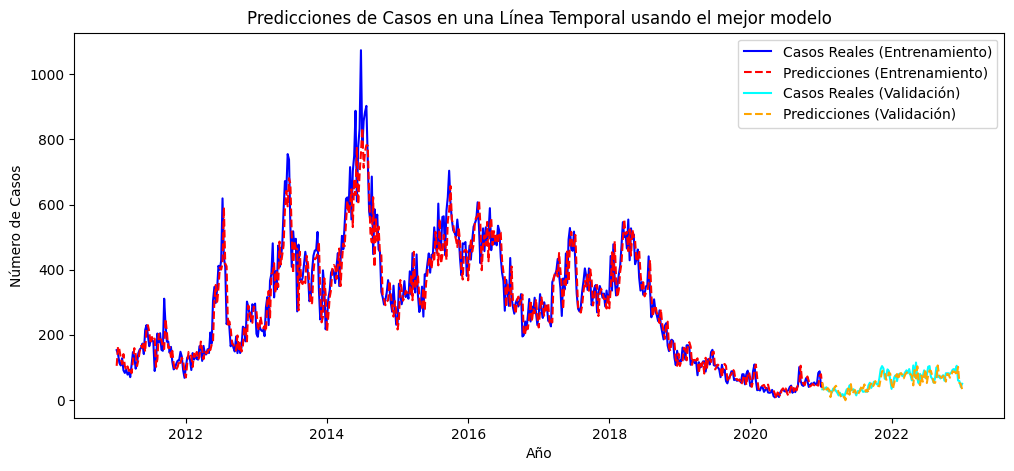

Valores de Cross-Correlation para T2M:
{-9: -0.17821195937978546, -8: -0.16699842026144304, -7: -0.1584333347469508, -6: -0.1504329797856819, -5: -0.15463573771863465, -4: -0.14166754038067125, -3: -0.13019252920408006, -2: -0.13487327591735976, -1: -0.13204971966795379}
Valor máximo: 
(-9, -0.17821195937978546)
Valores de Cross-Correlation para PRECTOTCORR:
{-9: 0.040429177694794136, -8: 0.05288811306902007, -7: 0.06859331498411211, -6: 0.10611989308085458, -5: 0.08808490883467542, -4: 0.06598308193476575, -3: 0.06256658848338714, -2: 0.0680408403947427, -1: 0.07149171401386424}
Valor máximo: 
(-6, 0.10611989308085458)
Valores de Cross-Correlation para RH2M:
{-9: 0.23971851555256793, -8: 0.22381436298355661, -7: 0.21771388846637718, -6: 0.2134250907468072, -5: 0.20889346275981763, -4: 0.20227445899790697, -3: 0.19369052453045657, -2: 0.1908797283157893, -1: 0.19262093213008608}
Valor máximo: 
(-9, 0.23971851555256793)
Valores de Cross-Correlation para WS2M:
{-9: 0.20819395727416842, -

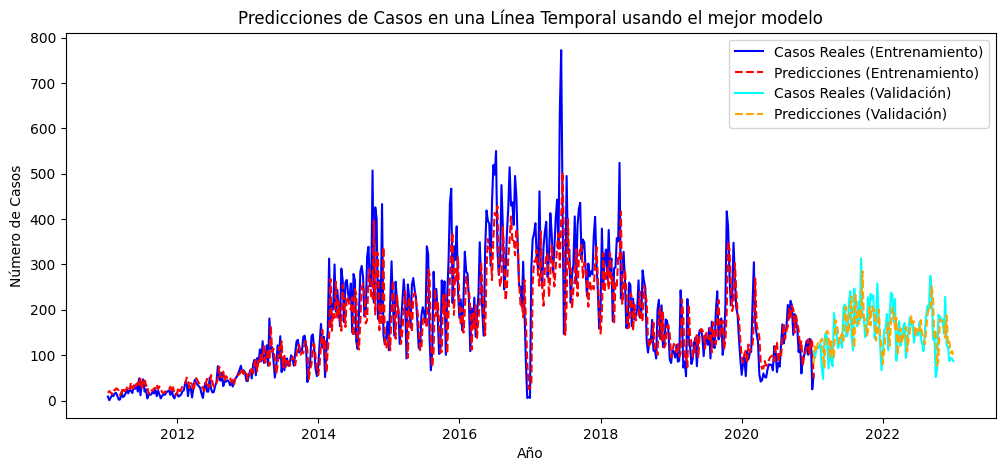

Valores de Cross-Correlation para T2M:
{-9: 0.07137433000192088, -8: 0.06266579859024353, -7: 0.04743959319487698, -6: 0.04409562626440013, -5: 0.0449227859350192, -4: 0.05292973640755513, -3: 0.05156713851442754, -2: 0.035790092537022186, -1: 0.015867093232352265}
Valor máximo: 
(-9, 0.07137433000192088)
Valores de Cross-Correlation para PRECTOTCORR:
{-9: -0.014018649804651997, -8: -0.020442758148750947, -7: -0.025351813567450584, -6: -0.06171716146116941, -5: -0.06106458101040188, -4: -0.06359881825198911, -3: -0.0847951362177884, -2: -0.08098821962369537, -1: -0.0824572852609399}
Valor máximo: 
(-3, -0.0847951362177884)
Valores de Cross-Correlation para RH2M:
{-9: 0.08805705667611564, -8: 0.0832865813739015, -7: 0.08461075860447669, -6: 0.06686951079018288, -5: 0.05935812414196988, -4: 0.056261388057005535, -3: 0.057772595895734795, -2: 0.04159508490532167, -1: 0.04261817396204851}
Valor máximo: 
(-9, 0.08805705667611564)
Valores de Cross-Correlation para WS2M:
{-9: 0.18109898283317

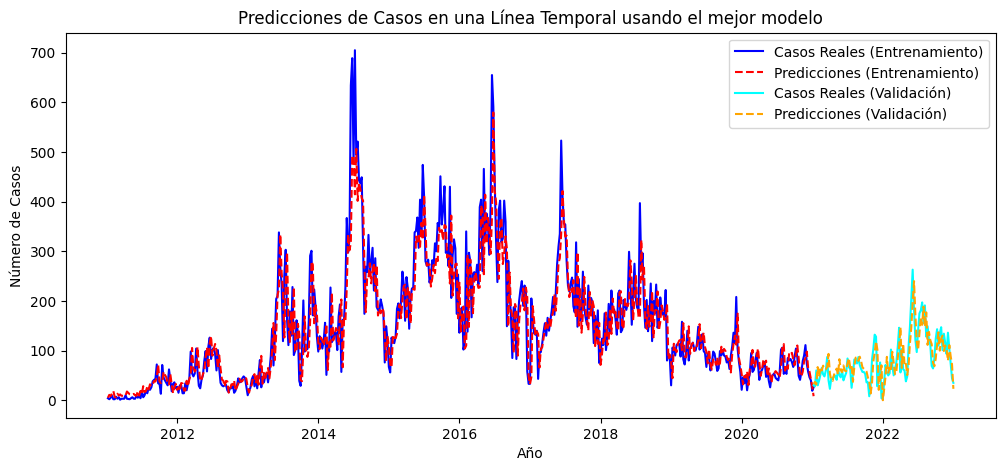

In [22]:
for df in malaria_final_dataset:
  Train_funtion(df)

##Dengue

Valores de Cross-Correlation para T2M:
{-9: 0.015456092095102078, -8: 0.01945594366628466, -7: 0.01822760491831847, -6: 0.026136666089487625, -5: 0.021005219574391686, -4: 0.014642288773559576, -3: 0.008626225385931535, -2: 0.000574435557646028, -1: 0.0006556498939458722}
Valor máximo: 
(-6, 0.026136666089487625)
Valores de Cross-Correlation para PRECTOTCORR:
{-9: -0.037923962577599106, -8: -0.04061751540661989, -7: -0.035000724717151516, -6: -0.03797563647639113, -5: -0.02817750273638432, -4: -0.029126288521873548, -3: -0.02845534499971079, -2: -0.017693267510937676, -1: -0.015837116403573867}
Valor máximo: 
(-8, -0.04061751540661989)
Valores de Cross-Correlation para RH2M:
{-9: 0.03627667644695034, -8: 0.030017021047050802, -7: 0.02873597183853771, -6: 0.019462559130496326, -5: 0.01985448985518135, -4: 0.02591333541374389, -3: 0.030948985309351855, -2: 0.046247675251861256, -1: 0.06126179769033245}
Valor máximo: 
(-1, 0.06126179769033245)
Valores de Cross-Correlation para WS2M:
{-9: 

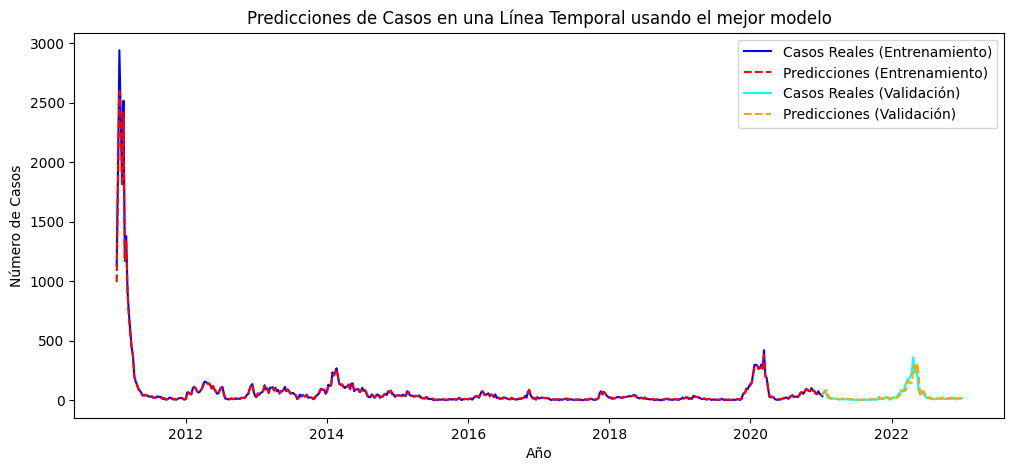

Valores de Cross-Correlation para T2M:
{-9: 0.19346936630749414, -8: 0.18361434324045894, -7: 0.17571014532594187, -6: 0.16331276645405246, -5: 0.15311167849682655, -4: 0.14167026999743068, -3: 0.1275659150766608, -2: 0.11165230797690269, -1: 0.09250806234107274}
Valor máximo: 
(-9, 0.19346936630749414)
Valores de Cross-Correlation para PRECTOTCORR:
{-9: 0.6643889170456382, -8: 0.7490859652320916, -7: 0.749358268683996, -6: 0.7422457932935953, -5: 0.6384655839987947, -4: 0.5157714604541198, -3: 0.3952906950993672, -2: 0.26187032545822064, -1: 0.1613904432811605}
Valor máximo: 
(-7, 0.749358268683996)
Valores de Cross-Correlation para RH2M:
{-9: 0.418693092386979, -8: 0.4670761468530764, -7: 0.4895695130735297, -6: 0.5110227269429325, -5: 0.5047947685503448, -4: 0.48675612505957727, -3: 0.4671648513967469, -2: 0.4354683990042752, -1: 0.40116788052297775}
Valor máximo: 
(-6, 0.5110227269429325)
Valores de Cross-Correlation para WS2M:
{-9: -0.36259734674619953, -8: -0.38523877793461125, -

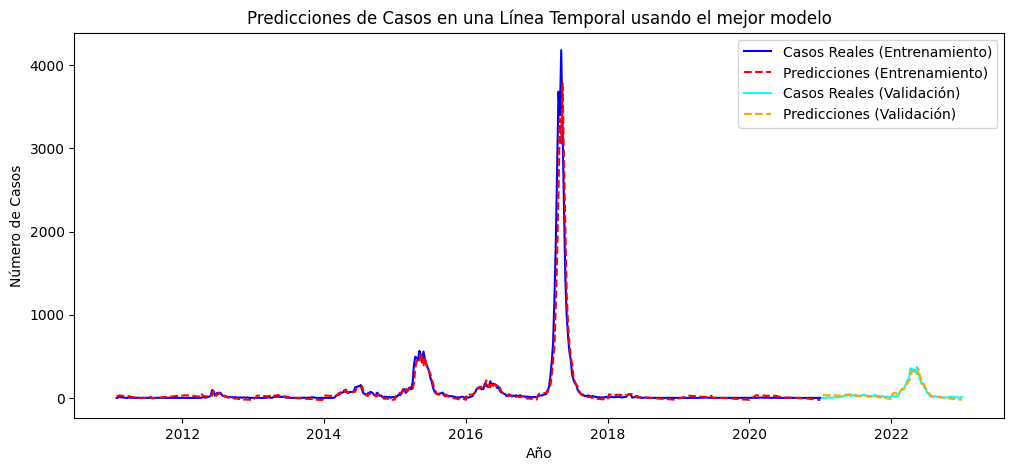

Valores de Cross-Correlation para T2M:
{-9: 0.2336531173900868, -8: 0.2170647305819745, -7: 0.19503973138479289, -6: 0.16468541785760887, -5: 0.14370991707823372, -4: 0.12057202705231014, -3: 0.11464170085653641, -2: 0.11542252497683324, -1: 0.1164966999466946}
Valor máximo: 
(-9, 0.2336531173900868)
Valores de Cross-Correlation para PRECTOTCORR:
{-9: -0.0613272410219446, -8: -0.04278658648094442, -7: -0.018673864919331526, -6: 0.0074599793093480336, -5: 0.01712255171598786, -4: 0.031070911253997056, -3: 0.002374099329216486, -2: -0.024965224468248903, -1: -0.030576708999751453}
Valor máximo: 
(-9, -0.0613272410219446)
Valores de Cross-Correlation para RH2M:
{-9: -0.21352718964059983, -8: -0.19080080681434153, -7: -0.16237546293393648, -6: -0.12498348180938318, -5: -0.09873828900307088, -4: -0.0700885081792226, -3: -0.05945483274501683, -2: -0.05895340466599234, -1: -0.055820149006720186}
Valor máximo: 
(-9, -0.21352718964059983)
Valores de Cross-Correlation para WS2M:
{-9: -0.17714948

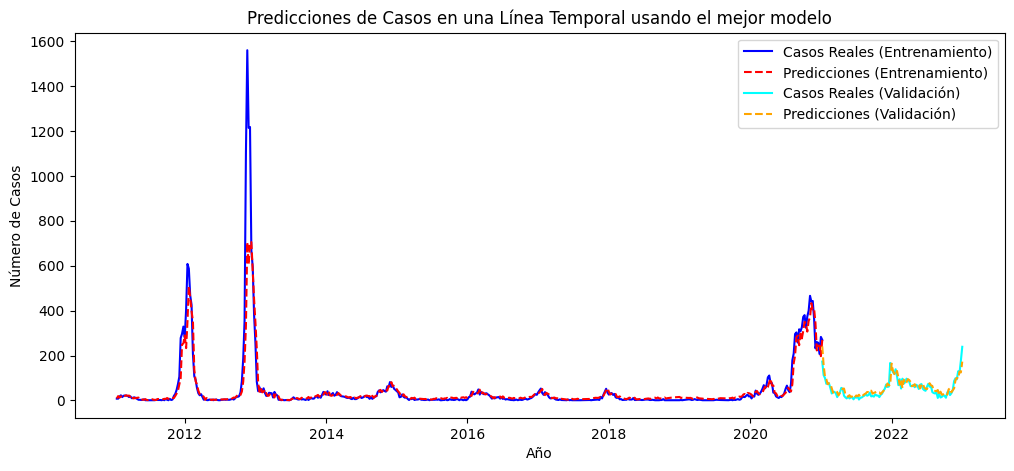

In [30]:
for df in dengue_final_dataset:
  Train_funtion(df)

###Nota: Los resultados pueden diferir ligeramente del mostrado en el reporte, debido a la iniciacion y aleatoriedad de los modelos usados.